# NAFLD detection using RNA-Seq data


__Content creators:__  Mahdi Anvari, Sadegh Rizi

**University of Tehran, Department of Biotechnology**

In this part, we need to assess whether clinical data such as BMI, age, sex, and diabetes are important enough to be included in our feature selection. Additionally, we will evaluate whether their inclusion improves upon our previous results. Let’s proceed and find out.

# Q2 - Python section ##

In [39]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
# Load Data
normal_counts = pd.read_csv('Normal.counts.voom.csv')
meta_data = pd.read_csv('meta_data.csv')

In [3]:
normal_counts.head()

,gene,DLDR_0001,DLDR_0002,DLDR_0003,DLDR_0004,DLDR_0005,DLDR_0006,DLDR_0007,DLDR_0008,DLDR_0009,...,DLDR_0183,DLDR_0184,DLDR_0185,DLDR_0186,DLDR_0187,DLDR_0188,DLDR_0189,DLDR_0190,DLDR_0191,DLDR_0192
0,ENSG00000000003,5.965571,5.741587,5.996891,5.551919,6.430237,6.234619,6.071503,6.441882,5.752712,...,6.304802,6.576246,6.735760,6.344234,6.608924,6.480745,6.360397,6.367705,6.604050,6.514539
1,ENSG00000000005,1.612375,2.147793,0.418542,0.702492,1.215978,0.920810,0.458163,0.927224,1.089389,...,-0.031596,-1.091275,-0.942637,-0.026585,-0.757399,-1.083676,0.886550,-0.902201,-0.865036,-1.588749
2,ENSG00000000419,4.133821,4.120969,4.086129,4.116240,4.393797,4.390909,4.148242,4.554655,4.203819,...,4.176599,4.244459,4.342765,4.179319,4.274450,4.361634,4.093280,4.148010,4.351489,3.859711
3,ENSG00000000457,4.111056,3.922234,3.964871,3.978350,4.018235,3.864521,4.263119,3.896271,4.139546,...,4.378342,4.453838,4.685598,4.438796,4.042577,4.313540,4.205119,4.506058,4.072137,4.341988
4,ENSG00000000460,4.150662,3.732756,3.634637,3.853979,3.614220,3.500857,4.000565,4.016287,3.904500,...,2.974209,3.720038,4.640011,3.814717,2.126408,3.120196,3.336802,3.982071,3.143138,2.741172


In [4]:
normal_counts.shape

(17396, 193)

In [5]:
meta_data.head()

,Patient_ID,SEX,BMI_surg,Age,Run,Diabet,Simplified_class
0,DLDR_0001,Female,35.214555,55,SRR8378590,Non Diabetic,Normal
1,DLDR_0002,Female,39.421748,47,SRR8378589,Diabetic,Normal
2,DLDR_0003,Male,48.758108,46,SRR8378432,Non Diabetic,Normal
3,DLDR_0004,Female,41.822607,36,SRR8378431,Non Diabetic,Normal
4,DLDR_0005,Female,53.582192,54,SRR8378434,Non Diabetic,Normal


In [6]:
meta_data.shape

(192, 7)

In [7]:
print("Number of Normal samples: ", meta_data['Simplified_class'].to_list().count("Normal"))
print("Number of Non_advanced_Fibrosis samples: ", meta_data['Simplified_class'].to_list().count("Non_advanced_Fibrosis"))
print("Number of Advanced_fibrosis: ", meta_data['Simplified_class'].to_list().count("Advanced_fibrosis"))

Number of Normal samples:  74
Number of Non_advanced_Fibrosis samples:  53
Number of Advanced_fibrosis:  65


To include our clinical data, we need to perform some preprocessing steps. For categorical data, we will use one-hot encoding, and for continuous data, we will apply normalization.

In [8]:
# One-Hot Encoding for categorical features
categorical_features = ['SEX', 'Diabet']
ohe = OneHotEncoder()
# Standardize continuous variables
numerical_features = ['BMI_surg', 'Age']
scaler = StandardScaler()
# Preprocess clinical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', ohe, categorical_features)])

In [9]:
clinical_data = preprocessor.fit_transform(meta_data)

In [10]:
clinical_data = pd.DataFrame(clinical_data).iloc[:, [0, 1, 2, 4]]
clinical_data.columns = ['BMI_surg', 'Age', 'Sex', 'Diabet']

In [11]:
clinical_data

,BMI_surg,Age,Sex,Diabet
0,-1.308155,0.855160,1.0,0.0
1,-0.857325,0.145913,1.0,1.0
2,0.143131,0.057257,0.0,0.0
3,-0.600056,-0.829302,1.0,0.0
4,0.660065,0.766504,1.0,0.0
...,...,...,...,...
187,-0.772196,1.209783,0.0,1.0
188,0.284524,0.589192,1.0,0.0
189,6.161411,-1.538548,0.0,1.0
190,0.007788,-0.829302,1.0,0.0


In [12]:
print(clinical_data.shape)
print(normal_counts.shape)

(192, 4)
(17396, 193)


In [13]:
gene_names = normal_counts.iloc[:,0]
gene_names.at[17396] = 'BMI_surg'
gene_names.at[17397] = 'Age'
gene_names.at[17398] = 'SEX'
gene_names.at[17399] = 'Diabet'

In [14]:
gene_names

0        ENSG00000000003
1        ENSG00000000005
2        ENSG00000000419
3        ENSG00000000457
4        ENSG00000000460
              ...       
17395    ENSG00000273294
17396           BMI_surg
17397                Age
17398                SEX
17399             Diabet
Name: gene, Length: 17400, dtype: object

Now, let's combine our gene expression data with clinical data

In [15]:
combined_data = np.hstack((normal_counts.iloc[0:,1:].T, clinical_data))
combined_data = pd.DataFrame(combined_data)

In [16]:
combined_data

,0,1,2,3,4,5,6,7,8,9,...,17390,17391,17392,17393,17394,17395,17396,17397,17398,17399
0,5.965571,1.612375,4.133821,4.111056,4.150662,2.975845,11.005488,4.405768,6.825329,4.221450,...,0.691230,5.637483,-0.005377,1.675800,2.683536,-0.339797,-1.308155,0.855160,1.0,0.0
1,5.741587,2.147793,4.120969,3.922234,3.732756,3.199989,10.860700,3.895350,6.453687,4.218183,...,1.004202,5.975612,0.532134,1.555218,2.926666,0.435919,-0.857325,0.145913,1.0,1.0
2,5.996891,0.418542,4.086129,3.964871,3.634637,2.949733,10.934025,4.282577,6.437658,3.736947,...,0.943633,5.531648,-0.184123,2.391906,2.260662,-0.691083,0.143131,0.057257,0.0,0.0
3,5.551919,0.702492,4.116240,3.978350,3.853979,2.991061,10.760445,4.297722,6.710840,4.003661,...,0.431190,5.571799,-0.034474,1.639298,2.341393,0.096771,-0.600056,-0.829302,1.0,0.0
4,6.430237,1.215978,4.393797,4.018235,3.614220,2.836130,11.491427,4.405558,7.437655,4.377965,...,0.085581,5.636848,-1.216981,1.974160,1.351861,-0.079478,0.660065,0.766504,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,6.480745,-1.083676,4.361634,4.313540,3.120196,1.941859,11.451981,4.556052,7.183779,5.066071,...,-0.431600,2.616763,1.063165,1.941859,-2.306069,0.632531,-0.772196,1.209783,0.0,1.0
188,6.360397,0.886550,4.093280,4.205119,3.336802,2.911496,11.658711,4.315153,7.384726,4.627703,...,-1.080284,2.975985,0.589568,2.754906,-0.839275,-0.016153,0.284524,0.589192,1.0,0.0
189,6.367705,-0.902201,4.148010,4.506058,3.982071,2.202136,11.864397,4.348255,7.326297,4.528530,...,-1.108652,3.218814,-0.416774,2.246191,-1.639167,0.145105,6.161411,-1.538548,0.0,1.0
190,6.604050,-0.865036,4.351489,4.072137,3.143138,4.037476,11.782524,4.358527,8.468526,5.013154,...,-0.624028,2.050571,-1.517113,2.084923,-4.324468,0.067849,0.007788,-0.829302,1.0,0.0


Let's split our data and labels to train and test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(combined_data, meta_data['Simplified_class'], test_size=0.3, random_state = 10101)

In [18]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,17390,17391,17392,17393,17394,17395,17396,17397,17398,17399
35,5.820135,-1.060061,4.388400,4.080172,2.564430,3.552685,11.011379,4.682305,6.951539,4.589555,...,-0.323095,3.157170,0.459313,3.115198,-2.645023,0.760969,-0.001936,-0.120055,1.0,0.0
80,6.546299,0.582165,3.752090,4.645175,3.840899,3.201075,11.433579,3.705547,7.143316,5.482169,...,0.582165,4.041596,0.096738,2.418666,-2.225190,0.582165,-0.661021,-1.361237,1.0,1.0
190,6.604050,-0.865036,4.351489,4.072137,3.143138,4.037476,11.782524,4.358527,8.468526,5.013154,...,-0.624028,2.050571,-1.517113,2.084923,-4.324468,0.067849,0.007788,-0.829302,1.0,0.0
187,6.480745,-1.083676,4.361634,4.313540,3.120196,1.941859,11.451981,4.556052,7.183779,5.066071,...,-0.431600,2.616763,1.063165,1.941859,-2.306069,0.632531,-0.772196,1.209783,0.0,1.0
129,6.550016,-1.222374,4.534941,4.370763,3.512952,2.517867,12.041229,4.315374,7.485927,4.655817,...,-0.981365,2.594319,0.447478,2.556600,-2.359877,0.932905,0.932361,-1.627204,1.0,0.0


In [19]:
X_train.shape

(134, 17400)

In [20]:
y_train.head()

35                    Normal
80         Advanced_fibrosis
190                   Normal
187                   Normal
129    Non_advanced_Fibrosis
Name: Simplified_class, dtype: object

In [21]:
y_train.shape

(134,)

In [22]:
print("Number of Normal samples: ", y_train.to_list().count("Normal"))
print("Number of Non_advanced_Fibrosis samples: ", y_train.to_list().count("Non_advanced_Fibrosis"))
print("Number of Advanced_fibrosis samples: ", y_train.to_list().count("Advanced_fibrosis"))

Number of Normal samples:  44
Number of Non_advanced_Fibrosis samples:  38
Number of Advanced_fibrosis samples:  52


Now, let’s save the training set data to use in the R Jupyter Notebook for feature selection

In [23]:
X_train.T.to_csv('train_normal_counts.csv', index=False)
y_train.T.to_csv('train_meta_data.csv', index=False)

#### Run R Jupyter Notebook

Let's load the output of R to continue the task and check if any clinical data have been selected or not

In [24]:
subset_data = pd.read_csv('subset_data.csv')

In [25]:
subset_data

,Unnamed: 0,X35,X80,X190,X187,X129,X12,X78,X130,X134,...,X174,X51,X86,X154,X91,X186,X185,X178,X181,X0
0,10,4.589555,5.482169,5.013154,5.066071,4.655817,4.299078,4.752957,5.409514,4.993777,...,4.853565,4.567173,4.985158,5.234776,4.900754,4.923087,5.004500,5.058062,5.002454,4.221450
1,57,-0.719024,0.582165,-1.154543,-1.083676,-0.289488,-0.006469,-1.138550,-4.060128,-2.104255,...,-2.285986,-0.110595,-0.385647,-3.580073,0.317259,-0.757399,-3.486017,-1.346471,-1.103280,-0.005377
2,265,0.587637,-2.225190,-0.076540,0.196432,0.272391,2.523150,1.424386,0.332190,0.217673,...,1.083248,0.352377,-0.309698,0.120366,0.890444,-0.291735,0.811664,-0.246936,0.416094,2.729099
3,275,1.662405,2.529697,1.508422,1.991612,1.467942,1.934152,2.031375,2.048397,0.528013,...,1.083248,2.556469,2.055951,1.374123,1.902221,1.838969,1.643266,1.272439,1.932344,2.467558
4,278,5.529902,5.846272,5.553583,5.359267,5.774549,4.962662,5.201300,5.500205,5.782051,...,5.862067,5.038603,5.665231,5.781140,5.745159,5.438062,5.570169,5.558701,5.733822,5.220121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,16863,3.811126,3.329399,2.183327,2.412750,3.323819,2.690386,3.515760,3.197260,2.112975,...,1.555316,3.901539,3.344479,1.911780,3.763838,3.667268,2.742802,2.446087,3.857108,2.844001
523,16887,3.576080,2.418666,3.355012,3.288878,3.231084,3.757011,2.435441,3.079423,2.393996,...,2.974541,3.737944,2.476362,2.817958,2.596331,3.203431,3.162640,2.353968,3.445156,3.271068
524,16892,4.007463,3.060212,2.951656,3.366357,2.649112,2.774044,3.123117,2.951099,2.974696,...,2.604785,3.934981,3.001089,2.596515,3.945549,4.002569,3.359473,3.497226,3.563476,2.830128
525,17075,6.925971,7.323632,7.411511,7.189120,7.519400,6.661844,7.087205,7.366661,7.586092,...,7.491543,6.721953,7.511299,7.684565,7.620817,7.419428,7.417614,7.354464,7.633460,6.752731


In [26]:
subset_data.shape

(527, 135)

We need to extract the same features for the X test dataset as well. To do this, we must identify the indices of our selected DEGs and apply the same subsetting to the test data.

In [27]:
selected_genes_R = subset_data.T.iloc[0,:].to_list()

In [28]:
selected_genes_Python = [int(i-1) for i in selected_genes_R ]

In [29]:
selected_genes_Python[:10]

[9, 56, 264, 274, 277, 296, 309, 340, 351, 389]

In [30]:
len(selected_genes_Python)

527

In [31]:
clinical_indices =[17396,17397,17398,17399]
common_members = set(selected_genes_Python).intersection(set(clinical_indices))
if common_members:
    print("Some clinical data is identified among DEGs")
else:
    print("No clinical data is identified among DEGs")

No clinical data is identified among DEGs


So in this case, no clinical data have been selected

### Classification

Now, we need to determine whether adding clinical data improves the performance of our classification models compared to the previous results. To evaluate this, we will perform classification under three conditions: 1- using only DEGs, 2- combining DEGs and clinical data, and 3- using only clinical data. This process will help us assess the impact of clinical data on classification, both with and without the presence of DEGs.

#### 1- Using only DEGs

In [32]:
df_deg = subset_data.iloc[0:,1:].T
df_deg_test = X_test[selected_genes_Python]

In [33]:
df_deg.head()

,0,1,2,3,4,5,6,7,8,9,...,517,518,519,520,521,522,523,524,525,526
X35,4.589555,-0.719024,0.587637,1.662405,5.529902,7.549487,0.318451,6.089009,5.898008,9.044188,...,3.104511,1.602904,0.915692,7.886943,5.319606,3.811126,3.576080,4.007463,6.925971,-2.645023
X80,5.482169,0.582165,-2.225190,2.529697,5.846272,7.759228,0.096738,6.539682,6.101239,8.633568,...,2.819204,1.234242,-0.640228,6.310085,3.797178,3.329399,2.418666,3.060212,7.323632,-2.225190
X190,5.013154,-1.154543,-0.076540,1.508422,5.553583,7.612538,1.033084,6.434588,6.098648,8.244201,...,2.275445,0.884985,0.067849,7.139567,3.909152,2.183327,3.355012,2.951656,7.411511,-4.324468
X187,5.066071,-1.083676,0.196432,1.991612,5.359267,8.070057,0.356896,6.476384,6.118797,7.951712,...,2.708882,0.356896,-0.431600,7.167637,4.021858,2.412750,3.288878,3.366357,7.189120,-3.891031
X129,4.655817,-0.289488,0.272391,1.467942,5.774549,7.439405,0.362589,6.486240,6.239292,8.248378,...,2.969247,1.248932,-1.222374,6.106913,3.570860,3.323819,3.231084,2.649112,7.519400,-4.681805


In [34]:
df_deg_test.head()

,9,56,264,274,277,296,309,340,351,389,...,16641,16686,16715,16731,16762,16862,16886,16891,17074,17186
21,3.967031,0.177378,2.880522,2.254454,5.101756,7.696151,2.077214,5.845657,5.444621,8.076772,...,2.825450,0.246091,0.928350,7.735892,4.644785,2.335526,3.460071,3.723708,6.646771,0.246091
15,4.603126,0.002788,2.608214,1.992446,5.079298,7.453528,2.274384,5.735367,5.394124,9.027927,...,2.934201,0.299770,0.488215,7.956485,5.527246,2.274384,3.722128,3.226652,6.739625,0.545930
3,4.003661,-0.178864,2.418699,2.287454,5.125878,6.943351,2.538993,6.049955,5.583037,8.243201,...,2.418699,0.217065,-0.519901,7.122512,3.978350,2.974088,3.280568,2.418699,6.827647,0.999473
164,5.286333,0.143691,0.332137,1.587791,5.827910,7.489948,1.225221,6.994423,6.261908,8.733452,...,2.368478,0.143691,0.389852,6.695064,3.291074,1.485611,2.862085,2.892352,7.434889,-3.697611
126,5.118729,-0.818750,0.897457,1.530400,5.446251,7.622416,0.897457,6.472366,5.832644,8.246698,...,2.137661,0.811301,1.128783,6.668899,3.631283,3.308569,2.881690,2.101816,7.391864,0.215197


##### Logistic Regression

In [40]:
# Logistic Regression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(df_deg, y_train)
y_pred_LR = LR_model.predict(df_deg_test)
LR_precision = precision_score(y_test, y_pred_LR, average='macro')
LR_recall = recall_score(y_test, y_pred_LR, average='macro')
print(LR_precision)
print(LR_recall)

0.7842803030303029
0.752991452991453


##### Support Vector Machine

In [41]:
# Support Vector Machine
SVM_model = SVC(kernel='linear', C=1)
SVM_model.fit(df_deg, y_train)
y_pred_SVM = SVM_model.predict(df_deg_test)
SVM_precision = precision_score(y_test, y_pred_SVM, average='macro')
SVM_recall = recall_score(y_test, y_pred_SVM, average='macro')
print(SVM_precision)
print(SVM_recall)

0.8441558441558442
0.8008547008547008


##### Random Forest

In [42]:
# Random Forest
RF_model = RandomForestClassifier(random_state = 10101)
RF_model.fit(df_deg, y_train)
y_pred_RF = RF_model.predict(df_deg_test)
RF_precision = precision_score(y_test, y_pred_RF, average='macro')
RF_recall = recall_score(y_test, y_pred_RF, average='macro')
print(RF_precision)
print(RF_recall)

0.7743589743589744
0.7606837606837606


##### Multi Layer Perceptron

In [43]:
# Multi Layer Perceptron
MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state = 10101)
MLP_model.fit(df_deg, y_train)
y_pred_MLP = MLP_model.predict(df_deg_test)
MLP_precision = precision_score(y_test, y_pred_MLP, average='macro')
MLP_recall = recall_score(y_test, y_pred_MLP, average='macro')
print(MLP_precision)
print(MLP_recall)

0.7317550505050505
0.7051282051282052


#### 2- Combining DEGs and clinical data

In [44]:
clinical_df_deg = np.hstack((df_deg,X_train[clinical_indices]))

In [45]:
clinical_df_deg = pd.DataFrame(clinical_df_deg)
clinical_df_deg.head()

,0,1,2,3,4,5,6,7,8,9,...,521,522,523,524,525,526,527,528,529,530
0,4.589555,-0.719024,0.587637,1.662405,5.529902,7.549487,0.318451,6.089009,5.898008,9.044188,...,5.319606,3.811126,3.576080,4.007463,6.925971,-2.645023,-0.001936,-0.120055,1.0,0.0
1,5.482169,0.582165,-2.225190,2.529697,5.846272,7.759228,0.096738,6.539682,6.101239,8.633568,...,3.797178,3.329399,2.418666,3.060212,7.323632,-2.225190,-0.661021,-1.361237,1.0,1.0
2,5.013154,-1.154543,-0.076540,1.508422,5.553583,7.612538,1.033084,6.434588,6.098648,8.244201,...,3.909152,2.183327,3.355012,2.951656,7.411511,-4.324468,0.007788,-0.829302,1.0,0.0
3,5.066071,-1.083676,0.196432,1.991612,5.359267,8.070057,0.356896,6.476384,6.118797,7.951712,...,4.021858,2.412750,3.288878,3.366357,7.189120,-3.891031,-0.772196,1.209783,0.0,1.0
4,4.655817,-0.289488,0.272391,1.467942,5.774549,7.439405,0.362589,6.486240,6.239292,8.248378,...,3.570860,3.323819,3.231084,2.649112,7.519400,-4.681805,0.932361,-1.627204,1.0,0.0


In [46]:
clinical_df_deg_test = np.hstack((df_deg_test,X_test[clinical_indices]))

In [47]:
clinical_df_deg_test = pd.DataFrame(clinical_df_deg_test)
clinical_df_deg_test.head()

,0,1,2,3,4,5,6,7,8,9,...,521,522,523,524,525,526,527,528,529,530
0,3.967031,0.177378,2.880522,2.254454,5.101756,7.696151,2.077214,5.845657,5.444621,8.076772,...,4.644785,2.335526,3.460071,3.723708,6.646771,0.246091,-0.082413,1.298439,1.0,0.0
1,4.603126,0.002788,2.608214,1.992446,5.079298,7.453528,2.274384,5.735367,5.394124,9.027927,...,5.527246,2.274384,3.722128,3.226652,6.739625,0.545930,-0.446496,-0.474678,1.0,0.0
2,4.003661,-0.178864,2.418699,2.287454,5.125878,6.943351,2.538993,6.049955,5.583037,8.243201,...,3.978350,2.974088,3.280568,2.418699,6.827647,0.999473,-0.600056,-0.829302,1.0,0.0
3,5.286333,0.143691,0.332137,1.587791,5.827910,7.489948,1.225221,6.994423,6.261908,8.733452,...,3.291074,1.485611,2.862085,2.892352,7.434889,-3.697611,0.875886,-1.183925,1.0,0.0
4,5.118729,-0.818750,0.897457,1.530400,5.446251,7.622416,0.897457,6.472366,5.832644,8.246698,...,3.631283,3.308569,2.881690,2.101816,7.391864,0.215197,-0.699417,-0.208711,1.0,1.0


##### Logistic Regression

In [48]:
# Logistic Regression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(clinical_df_deg, y_train)
y_pred_LR = LR_model.predict(clinical_df_deg_test)
LR_precision = precision_score(y_test, y_pred_LR, average='macro')
LR_recall = recall_score(y_test, y_pred_LR, average='macro')
print(LR_precision)
print(LR_recall)

0.8010912698412698
0.7752136752136751


##### Support Vector Machine

In [49]:
# Support Vector Machine
SVM_model = SVC(kernel='linear', C=1)
SVM_model.fit(clinical_df_deg, y_train)
y_pred_SVM = SVM_model.predict(clinical_df_deg_test)
SVM_precision = precision_score(y_test, y_pred_SVM, average='macro')
SVM_recall = recall_score(y_test, y_pred_SVM, average='macro')
print(SVM_precision)
print(SVM_recall)

0.8288084464555053
0.7752136752136751


##### Random Forest

In [50]:
# Random Forest
RF_model = RandomForestClassifier(random_state = 10101)
RF_model.fit(clinical_df_deg, y_train)
y_pred_RF = RF_model.predict(clinical_df_deg_test)
RF_precision = precision_score(y_test, y_pred_RF, average='macro')
RF_recall = recall_score(y_test, y_pred_RF, average='macro')
print(RF_precision)
print(RF_recall)

0.753968253968254
0.7461538461538462


##### Multi Layer Perceptron

In [51]:
# Multi Layer Perceptron
MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state = 10101)
MLP_model.fit(clinical_df_deg, y_train)
y_pred_MLP = MLP_model.predict(clinical_df_deg_test)
MLP_precision = precision_score(y_test, y_pred_MLP, average='macro')
MLP_recall = recall_score(y_test, y_pred_MLP, average='macro')
print(MLP_precision)
print(MLP_recall)

0.7662337662337663
0.7273504273504273


#### 3- using only clinical data

##### Logistic Regression

In [53]:
# Logistic Regression
LR_model = LogisticRegression(solver='saga')
LR_model.fit(X_train[clinical_indices], y_train)
y_pred_LR = LR_model.predict(X_test[clinical_indices])
LR_precision = precision_score(y_test, y_pred_LR, average='macro')
LR_recall = recall_score(y_test, y_pred_LR, average='macro')
print(LR_precision)
print(LR_recall)

0.49887766554433216
0.511965811965812


##### Support Vector Machine

In [158]:
# Support Vector Machine
SVM_model = SVC(kernel='linear', C=1)
SVM_model.fit(X_train[clinical_indices], y_train)

y_pred_SVM = SVM_model.predict(X_test[clinical_indices])
SVM_precision = precision_score(y_test, y_pred_SVM, average='macro')
SVM_recall = recall_score(y_test, y_pred_SVM, average='macro')
print(SVM_precision)
print(SVM_recall)

0.47980407944176057
0.511965811965812


##### Random Forest

In [54]:
# Random Forest
RF_model = RandomForestClassifier(random_state = 10101)
RF_model.fit(X_train[clinical_indices], y_train)
y_pred_RF = RF_model.predict(X_test[clinical_indices])
RF_precision = precision_score(y_test, y_pred_RF, average='macro')
RF_recall = recall_score(y_test, y_pred_RF, average='macro')
print(RF_precision)
print(RF_recall)

0.5344751866490997
0.5418803418803418


##### Multi Layer Perceptron

In [55]:
# Multi Layer Perceptron
MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state = 10101)
MLP_model.fit(X_train[clinical_indices], y_train)
y_pred_MLP = MLP_model.predict(X_test[clinical_indices])
MLP_precision = precision_score(y_test, y_pred_MLP, average='macro')
MLP_recall = recall_score(y_test, y_pred_MLP, average='macro')
print(MLP_precision)
print(MLP_recall)

0.5412962962962963
0.5307692307692308


So far, we have obtained only a single result for each classifier, but these results are not statistically valid. To test for reproducibility, we have put the entire process into a loop to run it 100 times. Additionally, we created an R script to perform DE analysis automatically using subprocess. Let’s run this cell and save the results for statistical analysis.

For each iteration, in addition to saving precision and recall for statistical validation, we need to check whether the clinical data have been included in our feature selection.

In [57]:
import subprocess

# Load Data
normal_counts = pd.read_csv('Normal.counts.voom.csv')
meta_data = pd.read_csv('meta_data.csv')

categorical_features = ['SEX', 'Diabet']
ohe = OneHotEncoder()
numerical_features = ['BMI_surg', 'Age']
scaler = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_features),
        ('cat', ohe, categorical_features)])
clinical_data = preprocessor.fit_transform(meta_data)
clinical_data = pd.DataFrame(clinical_data).iloc[:, [0, 1, 2, 4]]
clinical_data.columns = ['BMI_surg', 'Age', 'Sex', 'Diabet']
gene_names = normal_counts.iloc[:,0]
gene_names.at[17396] = 'BMI_surg'
gene_names.at[17397] = 'Age'
gene_names.at[17398] = 'SEX'
gene_names.at[17399] = 'Diabet'

combined_data = np.hstack((normal_counts.iloc[0:,1:].T, clinical_data))
combined_data = pd.DataFrame(combined_data)

n_iterations = 300
test_size = 0.3

LR_precisions = []
LR_recalls = []
LR_precisions2 = []
LR_recalls2 = []
LR_precisions3 = []
LR_recalls3 = []

SVM_precisions = []
SVM_recalls = []
SVM_precisions2 = []
SVM_recalls2 = []
SVM_precisions3 = []
SVM_recalls3 = []

RF_precisions = []
RF_recalls = []
RF_precisions2 = []
RF_recalls2 = []
RF_precisions3 = []
RF_recalls3 = []

MLP_precisions = []
MLP_recalls = []
MLP_precisions2 = []
MLP_recalls2 = []
MLP_precisions3 = []
MLP_recalls3 = []

for i in range(100):
    print('iteration',i)
    X_train, X_test, y_train, y_test = train_test_split(combined_data, meta_data['Simplified_class'], test_size=0.3, random_state = i)
    X_train.T.to_csv('train_normal_counts.csv', index=False)
    y_train.T.to_csv('train_meta_data.csv', index=False)

    r_script_path = r"q2r.R"
    rscript_path = r"C:\Program Files\R\R-4.2.1\bin\Rscript.exe"
    # Execute the R script
    try:
    	subprocess.run([rscript_path, r_script_path], capture_output=True, text=True)
    except subprocess.CalledProcessError as e:
    	print(f"Error executing R script: {e}")

    #
    subset_data = pd.read_csv('subset_data.csv')
    selected_genes_R = subset_data.T.iloc[0,:].to_list()
    selected_genes_Python = [int(i-1) for i in selected_genes_R ]

    clinical_indices =[17396,17397,17398,17399]
    common_members = set(selected_genes_Python).intersection(set(clinical_indices))
    if common_members:
        print("Some clinical data is identified among DEGs")
    else:
        print("No clinical data is identified among DEGs")
    
    df_deg = subset_data.iloc[0:,1:].T
    df_deg_test = X_test[selected_genes_Python]

    # Logistic Regression
    LR_model = LogisticRegression(solver='saga')
    LR_model.fit(df_deg, y_train)
    y_pred_LR = LR_model.predict(df_deg_test)
    LR_precision = precision_score(y_test, y_pred_LR, average='macro')
    LR_recall = recall_score(y_test, y_pred_LR, average='macro')
    LR_precisions.append(LR_precision)
    LR_recalls.append(LR_recall)

    # Support Vector Machine
    SVM_model = SVC(kernel='linear', C=1)
    SVM_model.fit(df_deg, y_train)
    y_pred_SVM = SVM_model.predict(df_deg_test)
    SVM_precision = precision_score(y_test, y_pred_SVM, average='macro')
    SVM_recall = recall_score(y_test, y_pred_SVM, average='macro')
    SVM_precisions.append(SVM_precision)
    SVM_recalls.append(SVM_recall)

    # Random Forest
    RF_model = RandomForestClassifier(random_state = i)
    RF_model.fit(df_deg, y_train)
    y_pred_RF = RF_model.predict(df_deg_test)
    RF_precision = precision_score(y_test, y_pred_RF, average='macro')
    RF_recall = recall_score(y_test, y_pred_RF, average='macro')
    RF_precisions.append(RF_precision)
    RF_recalls.append(RF_recall)

    # Multi Layer Perceptron
    MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam', random_state = i)
    MLP_model.fit(df_deg, y_train)
    y_pred_MLP = MLP_model.predict(df_deg_test)
    MLP_precision = precision_score(y_test, y_pred_MLP, average='macro')
    MLP_recall = recall_score(y_test, y_pred_MLP, average='macro')
    MLP_precisions.append(MLP_precision)
    MLP_recalls.append(MLP_recall)


    clinical_df_deg = np.hstack((df_deg,X_train[clinical_indices]))
    clinical_df_deg = pd.DataFrame(clinical_df_deg)
    clinical_df_deg_test = np.hstack((df_deg_test,X_test[clinical_indices]))
    clinical_df_deg_test = pd.DataFrame(clinical_df_deg_test)

    # Logistic Regression
    LR_model = LogisticRegression(solver='saga')
    LR_model.fit(clinical_df_deg, y_train)
    y_pred_LR = LR_model.predict(clinical_df_deg_test)
    LR_precision = precision_score(y_test, y_pred_LR, average='macro')
    LR_recall = recall_score(y_test, y_pred_LR, average='macro')
    LR_precisions2.append(LR_precision)
    LR_recalls2.append(LR_recall)

    # Support Vector Machine
    SVM_model = SVC(kernel='linear', C=1)
    SVM_model.fit(clinical_df_deg, y_train)
    y_pred_SVM = SVM_model.predict(clinical_df_deg_test)
    SVM_precision = precision_score(y_test, y_pred_SVM, average='macro')
    SVM_recall = recall_score(y_test, y_pred_SVM, average='macro')
    SVM_precisions2.append(SVM_precision)
    SVM_recalls2.append(SVM_recall)

    # Random Forest
    RF_model = RandomForestClassifier(random_state = i)
    RF_model.fit(clinical_df_deg, y_train)
    y_pred_RF = RF_model.predict(clinical_df_deg_test)
    RF_precision = precision_score(y_test, y_pred_RF, average='macro')
    RF_recall = recall_score(y_test, y_pred_RF, average='macro')
    RF_precisions2.append(RF_precision)
    RF_recalls2.append(RF_recall)

    # Multi Layer Perceptron
    MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state = i)
    MLP_model.fit(clinical_df_deg, y_train)
    y_pred_MLP = MLP_model.predict(clinical_df_deg_test)
    MLP_precision = precision_score(y_test, y_pred_MLP, average='macro')
    MLP_recall = recall_score(y_test, y_pred_MLP, average='macro')
    MLP_precisions2.append(MLP_precision)
    MLP_recalls2.append(MLP_recall)



    # Logistic Regression
    LR_model = LogisticRegression(solver='saga')
    LR_model.fit(X_train[clinical_indices], y_train)
    y_pred_LR = LR_model.predict(X_test[clinical_indices])
    LR_precision = precision_score(y_test, y_pred_LR, average='macro')
    LR_recall = recall_score(y_test, y_pred_LR, average='macro')
    LR_precisions3.append(LR_precision)
    LR_recalls3.append(LR_recall)

    # Support Vector Machine
    SVM_model = SVC(kernel='linear', C=1)
    SVM_model.fit(X_train[clinical_indices], y_train)
    y_pred_SVM = SVM_model.predict(X_test[clinical_indices])
    SVM_precision = precision_score(y_test, y_pred_SVM, average='macro')
    SVM_recall = recall_score(y_test, y_pred_SVM, average='macro')
    SVM_precisions3.append(SVM_precision)
    SVM_recalls3.append(SVM_recall)

    # Random Forest
    RF_model = RandomForestClassifier(random_state = i)
    RF_model.fit(X_train[clinical_indices], y_train)
    y_pred_RF = RF_model.predict(X_test[clinical_indices])
    RF_precision = precision_score(y_test, y_pred_RF, average='macro')
    RF_recall = recall_score(y_test, y_pred_RF, average='macro')
    RF_precisions3.append(RF_precision)
    RF_recalls3.append(RF_recall)

    # Multi Layer Perceptron
    MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation='relu', solver='adam',random_state = i)
    MLP_model.fit(X_train[clinical_indices], y_train)
    y_pred_MLP = MLP_model.predict(X_test[clinical_indices])
    MLP_precision = precision_score(y_test, y_pred_MLP, average='macro')
    MLP_recall = recall_score(y_test, y_pred_MLP, average='macro')
    MLP_precisions3.append(MLP_precision)
    MLP_recalls3.append(MLP_recall)


iteration 0
No clinical data is identified among DEGs
iteration 1
No clinical data is identified among DEGs
iteration 2
No clinical data is identified among DEGs
iteration 3
No clinical data is identified among DEGs
iteration 4
No clinical data is identified among DEGs
iteration 5
No clinical data is identified among DEGs
iteration 6
No clinical data is identified among DEGs
iteration 7
No clinical data is identified among DEGs
iteration 8
No clinical data is identified among DEGs
iteration 9
No clinical data is identified among DEGs
iteration 10
No clinical data is identified among DEGs
iteration 11
No clinical data is identified among DEGs
iteration 12
No clinical data is identified among DEGs
iteration 13
No clinical data is identified among DEGs
iteration 14
No clinical data is identified among DEGs
iteration 15
No clinical data is identified among DEGs
iteration 16
No clinical data is identified among DEGs
iteration 17
No clinical data is identified among DEGs
iteration 18
No clin

As you can see, clinical data were not selected in any of the iterations.

Last but not least, we need to report the average and confidence interval for the results of each classifier. We will also create a bar plot to visually compare the results of the classifiers. We also need to compare the results of the three conditions to determine whether adding clinical data has a significant effect on performance or not.

In [58]:
def Evaluation(LR_precisions,LR_recalls,SVM_precisions,SVM_recalls,RF_precisions,RF_recalls,MLP_precisions,MLP_recalls):

  LR_mean_precision = np.mean(LR_precisions)
  LR_mean_recall = np.mean(LR_recalls)
  LR_precision_conf_interval = np.percentile(LR_precisions, [2.5, 97.5])
  LR_recall_conf_interval = np.percentile(LR_recalls, [2.5, 97.5])
  print(f'Mean Precision for Logistic Regression: {LR_mean_precision}, 95% CI: {LR_precision_conf_interval}')
  print(f'Mean Recall for Logistic Regression: {LR_mean_recall}, 95% CI: {LR_recall_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  SVM_mean_precision = np.mean(SVM_precisions)
  SVM_mean_recall = np.mean(SVM_recalls)
  SVM_precision_conf_interval = np.percentile(SVM_precisions, [2.5, 97.5])
  SVM_recall_conf_interval = np.percentile(SVM_recalls, [2.5, 97.5])
  print(f'Mean Precision for Support Vector Machine: {SVM_mean_precision}, 95% CI: {SVM_precision_conf_interval}')
  print(f'Mean Recall for Support Vector Machine: {SVM_mean_recall}, 95% CI: {SVM_recall_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  RF_mean_precision = np.mean(RF_precisions)
  RF_mean_recall = np.mean(RF_recalls)
  RF_precision_conf_interval = np.percentile(RF_precisions, [2.5, 97.5])
  RF_recall_conf_interval = np.percentile(RF_recalls, [2.5, 97.5])
  print(f'Mean Precision for Random Forest: {RF_mean_precision}, 95% CI: {RF_precision_conf_interval}')
  print(f'Mean Recall for Random Forest: {RF_mean_recall}, 95% CI: {RF_recall_conf_interval}')
  print("-------------------------------------------------------------------------------------------------")

  MLP_mean_precision = np.mean(MLP_precisions)
  MLP_mean_recall = np.mean(MLP_recalls)
  MLP_precision_conf_interval = np.percentile(MLP_precisions, [2.5, 97.5])
  MLP_recall_conf_interval = np.percentile(MLP_recalls, [2.5, 97.5])
  print(f'Mean Precision for Multi Layer Perceptron: {MLP_mean_precision}, 95% CI: {MLP_precision_conf_interval}')
  print(f'Mean Recall for Multi Layer Perceptron: {MLP_mean_recall}, 95% CI: {MLP_recall_conf_interval}')

  model_results = {
      'RandomForest': {
          'mean_precision': RF_mean_precision,
          'precision_ci': RF_precision_conf_interval,
          'mean_recall': RF_mean_recall,
          'recall_ci': RF_precision_conf_interval
      },
      'SVM': {
          'mean_precision': SVM_mean_precision,
          'precision_ci': SVM_precision_conf_interval,
          'mean_recall': SVM_mean_recall,
          'recall_ci': SVM_precision_conf_interval
      },
          'LogisticRegression': {
          'mean_precision': LR_mean_precision,
          'precision_ci': LR_precision_conf_interval,
          'mean_recall': LR_mean_recall,
          'recall_ci': LR_precision_conf_interval
      },
      'MLP': {
          'mean_precision': MLP_mean_precision,
          'precision_ci': MLP_precision_conf_interval,
          'mean_recall': MLP_mean_recall,
          'recall_ci': MLP_precision_conf_interval
      }
  }

  models = list(model_results.keys())
  mean_precisions = [model_results[model]['mean_precision'] for model in models]
  precision_cis = [model_results[model]['precision_ci'] for model in models]
  mean_recalls = [model_results[model]['mean_recall'] for model in models]
  recall_cis = [model_results[model]['recall_ci'] for model in models]
  precision_errors = np.array([[mean - ci[0], ci[1] - mean] for mean, ci in zip(mean_precisions, precision_cis)]).T
  recall_errors = np.array([[mean - ci[0], ci[1] - mean] for mean, ci in zip(mean_recalls, recall_cis)]).T


  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  # Plot precision
  ax[0].bar(models, mean_precisions, yerr=precision_errors, capsize=5, color='skyblue')
  ax[0].set_title('Mean Precision with 95% Confidence Interval')
  ax[0].set_ylabel('Precision')
  ax[0].set_ylim([0.4, 1])
  ax[0].set_xticklabels(models, rotation=45, ha="right")

  # Plot recall
  ax[1].bar(models, mean_recalls, yerr=recall_errors, capsize=5, color='lightgreen')
  ax[1].set_title('Mean Recall with 95% Confidence Interval')
  ax[1].set_ylabel('Recall')
  ax[1].set_ylim([0.4, 1])
  ax[1].set_xticklabels(models, rotation=45, ha="right")

  plt.tight_layout()
  plt.show()

#### 1- Using only DEGs

Mean Precision for Logistic Regression: 0.7640169927513462, 95% CI: [0.64210043 0.85890152]
Mean Recall for Logistic Regression: 0.7651338428612129, 95% CI: [0.63696044 0.87401786]
-------------------------------------------------------------------------------------------------
Mean Precision for Support Vector Machine: 0.7743040927880918, 95% CI: [0.66116453 0.85674319]
Mean Recall for Support Vector Machine: 0.7723320280185707, 95% CI: [0.65753472 0.86513971]
-------------------------------------------------------------------------------------------------
Mean Precision for Random Forest: 0.7860810773240244, 95% CI: [0.6725455  0.87525208]
Mean Recall for Random Forest: 0.7867412414621653, 95% CI: [0.65607372 0.88233974]
-------------------------------------------------------------------------------------------------
Mean Precision for Multi Layer Perceptron: 0.7677514303520464, 95% CI: [0.65656233 0.85438582]
Mean Recall for Multi Layer Perceptron: 0.7618658834643532, 95% CI: [0.614

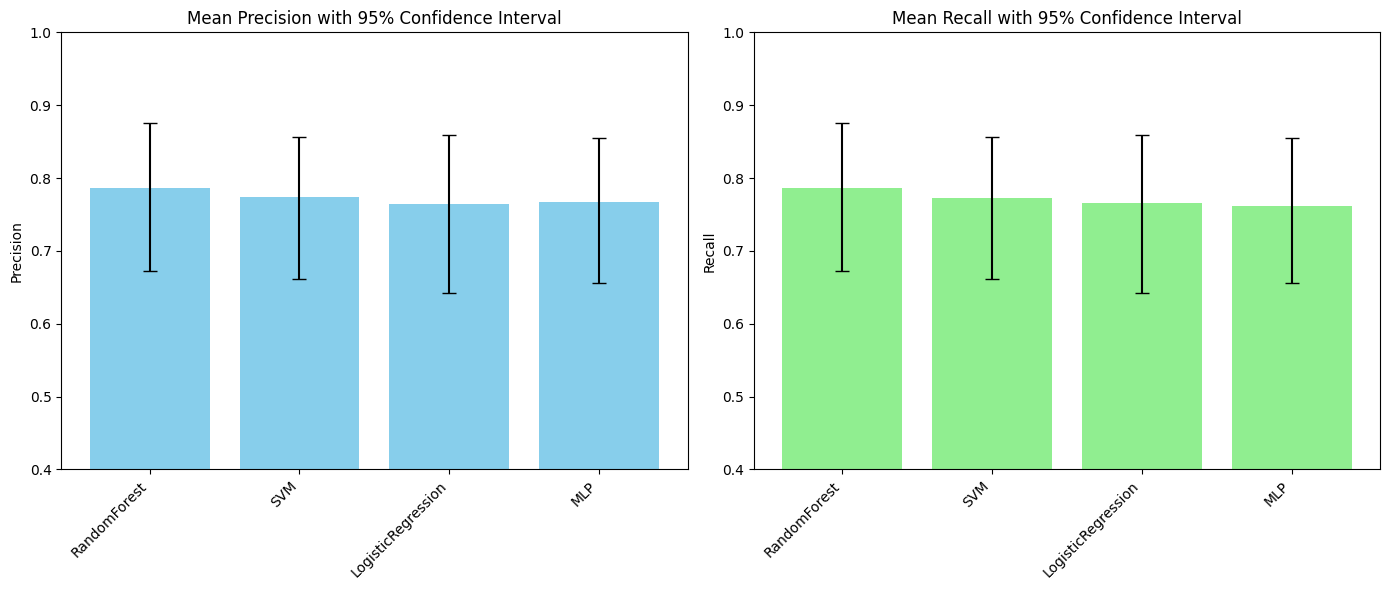

In [59]:
Evaluation(LR_precisions,LR_recalls,SVM_precisions,SVM_recalls,RF_precisions,RF_recalls,MLP_precisions,MLP_recalls)

#### 2- Combining DEGs and clinical data

Mean Precision for Logistic Regression: 0.7657572934644726, 95% CI: [0.64076229 0.86249775]
Mean Recall for Logistic Regression: 0.766437798402862, 95% CI: [0.63156272 0.87401786]
-------------------------------------------------------------------------------------------------
Mean Precision for Support Vector Machine: 0.7773571309688684, 95% CI: [0.68729898 0.85893579]
Mean Recall for Support Vector Machine: 0.7760440256206106, 95% CI: [0.67974551 0.85704685]
-------------------------------------------------------------------------------------------------
Mean Precision for Random Forest: 0.7853592442842011, 95% CI: [0.6831345  0.86472959]
Mean Recall for Random Forest: 0.7858822709176627, 95% CI: [0.68036487 0.86493412]
-------------------------------------------------------------------------------------------------
Mean Precision for Multi Layer Perceptron: 0.7649651583043456, 95% CI: [0.65414083 0.85956706]
Mean Recall for Multi Layer Perceptron: 0.7626787599565183, 95% CI: [0.6562

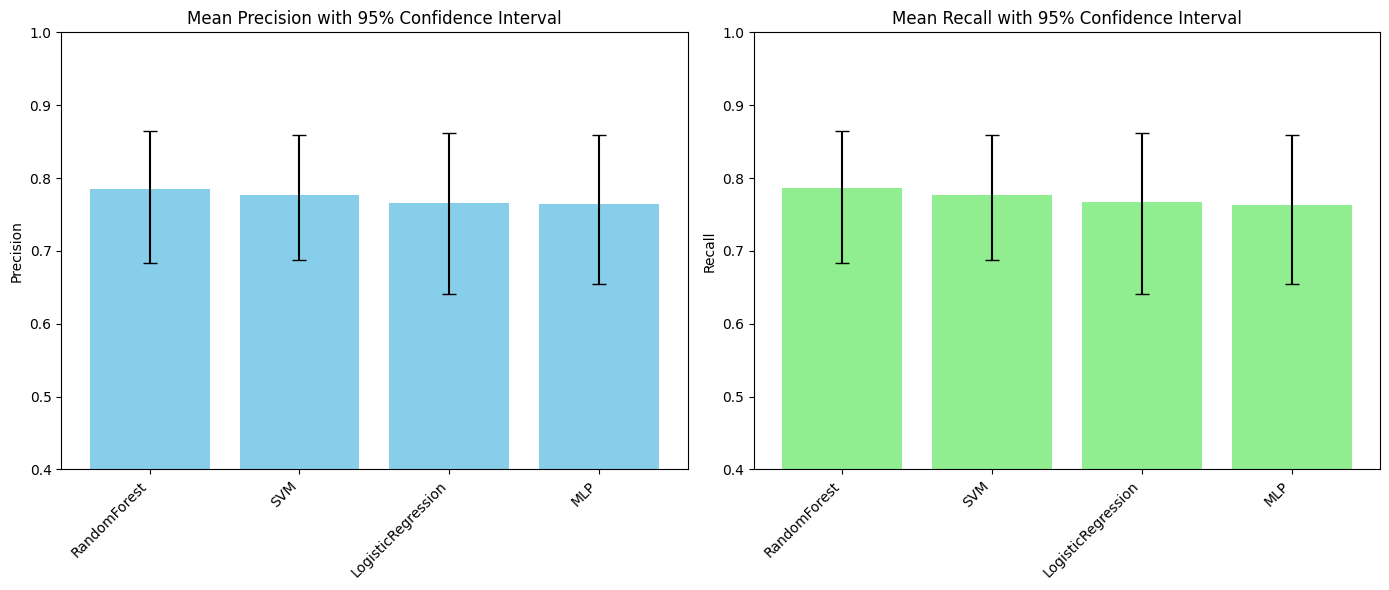

In [60]:
Evaluation(LR_precisions2,LR_recalls2,SVM_precisions2,SVM_recalls2,RF_precisions2,RF_recalls2,MLP_precisions2,MLP_recalls2)

#### 3- using only clinical data

Mean Precision for Logistic Regression: 0.515218903229282, 95% CI: [0.31170101 0.66907334]
Mean Recall for Logistic Regression: 0.47621360370841015, 95% CI: [0.36085483 0.59306812]
-------------------------------------------------------------------------------------------------
Mean Precision for Support Vector Machine: 0.4216381464824728, 95% CI: [0.25569444 0.65331303]
Mean Recall for Support Vector Machine: 0.45489894310748175, 95% CI: [0.36710967 0.55240385]
-------------------------------------------------------------------------------------------------
Mean Precision for Random Forest: 0.4311592063399727, 95% CI: [0.33722599 0.53896528]
Mean Recall for Random Forest: 0.4260025261322037, 95% CI: [0.33441138 0.52781951]
-------------------------------------------------------------------------------------------------
Mean Precision for Multi Layer Perceptron: 0.4748118320079058, 95% CI: [0.33603222 0.59929803]
Mean Recall for Multi Layer Perceptron: 0.4600780548510615, 95% CI: [0.33

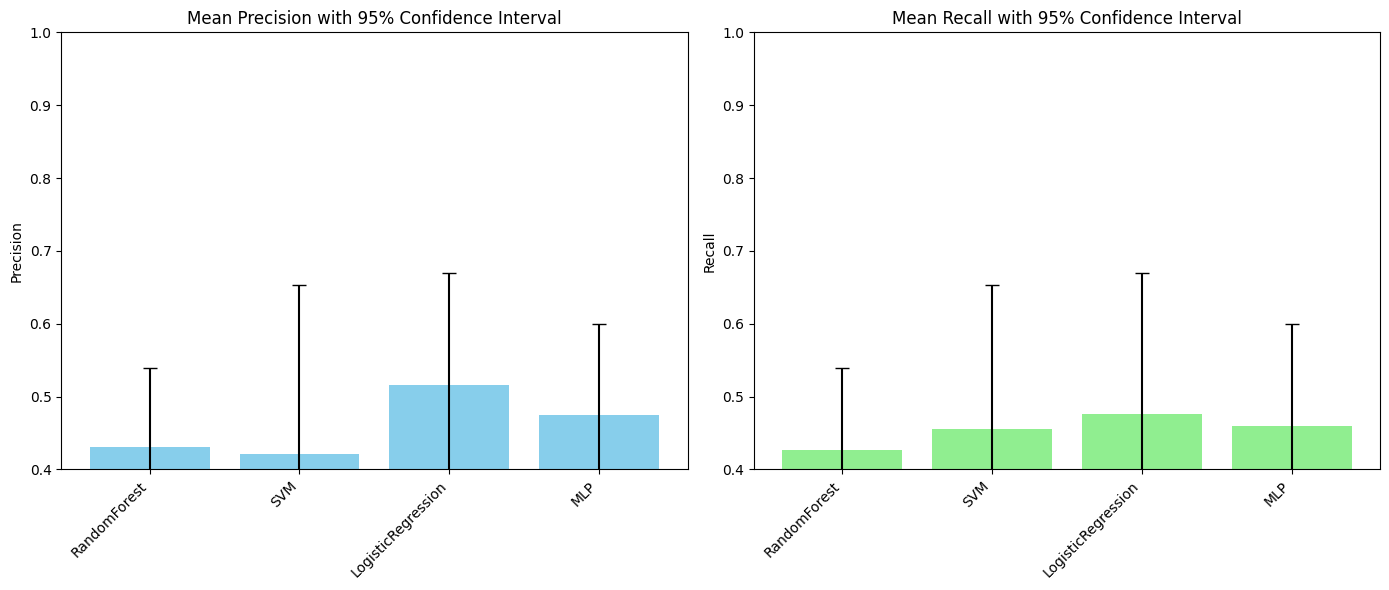

In [61]:
Evaluation(LR_precisions3,LR_recalls3,SVM_precisions3,SVM_recalls3,RF_precisions3,RF_recalls3,MLP_precisions3,MLP_recalls3)

As you can see, adding clinical data to DEGs does not have a significant effect on model performance, and the clinical data alone are not strong features for this classification task.